##Imports and Conection with GDrive

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
import seaborn as sns

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir('/content/drive/MyDrive/')
# enter the path of the folder where the out file is located
path = "/content/drive/MyDrive/Artigos_IC/"
os.chdir(path)
import shutil
shutil.copy('/content/drive/MyDrive/Artigos_IC/out.csv', '/content/')

Mounted at /content/drive


'/content/out.csv'

##Read Dataset csv as dataframe

In [3]:
# Uploading the CSV file
df = pd.read_csv('/content/out.csv')


/tmp/ipython-input-1384734811.py:2: DtypeWarning: Columns (7,71,72,73,74,75,156) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/out.csv')


In [4]:
#List columns ImprovMLCQ
df.columns.values

array(['system_id', 'commit_hash', 'start_line', 'end_line', 'smell',
       'id', 'reviewer_id', 'sample_id', 'severity', 'longmethod_label',
       'featureenvy_label', 'dataclass_label', 'blob_label',
       'agreement_has_smell', 'agreement_experts_has_smell',
       'agreement_smell_type', 'system_name', 'review_timestamp', 'type',
       'code_name', 'repository', 'path', 'link',
       'is_from_industry_relevant_project', 'organic_filerelativepath',
       'organic_startline', 'organic_endline', 'organic_weighofclass',
       'organic_numberofaccessormethods',
       'organic_classeffectivelinesofcode', 'organic_lcom3',
       'organic_tightclasscohesion', 'organic_isabstract',
       'organic_publicfieldcount', 'organic_overrideratio',
       'organic_weightedmethodcount', 'smell_organic',
       'organic_smellreason', 'organic_changingmethods',
       'organic_numberoftrystatements', 'organic_maxnesting',
       'organic_numberoffinallystatements',
       'organic_numberofthro

In [5]:
tool = ['organic', 'pmd', 'designite']
smell = ['longmethod', 'featureenvy', 'dataclass', 'blob']

df_result = df.copy()

####Confusion Matrix: Long Method


In [6]:
def ComputeMatrix(df_result):
  # Initialize an empty DataFrame
  df_matrix = pd.DataFrame()

  for i in tool:
    code_smelly = []
    non_code_smelly = []
    for j in smell:# Count the number of occurrences of 0 in column 'smell_Organic_longmethod'
      if not((i == 'PMD') and (j == 'featureenvy')) and not((i == 'Designite') and (j == 'dataclass')) and not((i == 'Designite') and (j == 'blob')):
        TP = ((df_result[''+j+'_label'] == 1) & (df_result['severity'] != 'none') & (df_result['smell_' +i+ '_' +j+ ''] == 1)).sum()
        FP = ((df_result[''+j+'_label'] == 1) & (df_result['severity'] == 'none') & (df_result['smell_' +i+ '_' +j+ ''] == 1)).sum()
        FN = ((df_result[''+j+'_label'] == 1) & (df_result['severity'] != 'none') & (df_result['smell_' +i+ '_' +j+ ''] == 0)).sum()
        TN = ((df_result[''+j+'_label'] == 1) & (df_result['severity'] == 'none') & (df_result['smell_' +i+ '_' +j+ ''] == 0)).sum()

        code_smelly.append(TP)
        code_smelly.append(FN)
        non_code_smelly.append(FP)
        non_code_smelly.append(TN)
      else:
        code_smelly.append(0)
        code_smelly.append(0)
        non_code_smelly.append(0)
        non_code_smelly.append(0)

    df_matrix['code smelly' +i+ ''] = code_smelly
    df_matrix['non-code smelly' +i+ ''] = non_code_smelly

  return df_matrix

In [7]:
df_result_matrix = ComputeMatrix(df_result)
df_result_matrix = df_result_matrix.T

# Convert DataFrame to LaTeX
latex_table = df_result_matrix.to_latex(index=True)
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 \\
\midrule
code smellyorganic & 120 & 830 & 29 & 474 & 70 & 1236 & 104 & 1203 \\
non-code smellyorganic & 3 & 217 & 36 & 592 & 10 & 706 & 36 & 784 \\
code smellypmd & 43 & 907 & 0 & 503 & 191 & 1115 & 270 & 1037 \\
non-code smellypmd & 2 & 218 & 0 & 628 & 36 & 680 & 80 & 740 \\
code smellydesignite & 99 & 851 & 0 & 503 & 0 & 1306 & 0 & 1307 \\
non-code smellydesignite & 15 & 205 & 0 & 628 & 0 & 716 & 0 & 820 \\
\bottomrule
\end{tabular}



In [8]:
def ComputeMCC(df_result):
  # Initialize an empty DataFrame
  df_MCC = pd.DataFrame()

  for i in tool:
    MCC_smell = []
    for j in smell:
      # Count the number of occurrences of 0 in column 'smell_Organic_longmethod'
      TP = ((df_result[''+j+'_label'] == 1) & (df_result['severity'] != 'none') & (df_result['smell_' +i+ '_' +j+ ''] == 1)).sum()
      FP = ((df_result[''+j+'_label'] == 1) & (df_result['severity'] == 'none') & (df_result['smell_' +i+ '_' +j+ ''] == 1)).sum()
      FN = ((df_result[''+j+'_label'] == 1) & (df_result['severity'] != 'none') & (df_result['smell_' +i+ '_' +j+ ''] == 0)).sum()
      TN = ((df_result[''+j+'_label'] == 1) & (df_result['severity'] == 'none') & (df_result['smell_' +i+ '_' +j+ ''] == 0)).sum()

      # Calcular o MCC
      MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
      MCC_smell.append(MCC)
      # print(MCC_smell)

    df_MCC['MCC_' +i+ ''] = MCC_smell
    # print(df_MCC)

  return df_MCC

In [9]:
df_result_MCC = ComputeMCC(df_result)
df_result_MCC = df_result_MCC.T
display(df_result_MCC)

# Convert DataFrame to LaTeX
latex_table = df_result_MCC.to_latex(index=True)
print(latex_table)

/tmp/ipython-input-3811985358.py:15: RuntimeWarning: invalid value encountered in scalar divide
  MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
/tmp/ipython-input-3811985358.py:15: RuntimeWarning: invalid value encountered in scalar divide
  MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))


,0,1,2,3
MCC_organic,0.143546,0.000703,0.097232,0.070012
MCC_pmd,0.073496,NaN,0.145383,0.143110
MCC_designite,0.047472,NaN,NaN,NaN


\begin{tabular}{lrrrr}
\toprule
 & 0 & 1 & 2 & 3 \\
\midrule
MCC_organic & 0.143546 & 0.000703 & 0.097232 & 0.070012 \\
MCC_pmd & 0.073496 & NaN & 0.145383 & 0.143110 \\
MCC_designite & 0.047472 & NaN & NaN & NaN \\
\bottomrule
\end{tabular}



## Severity X tool agreement smells types

In [10]:
# Calculating Percentage
def ComputePercent(df_graph):
  for i in tool:
    for j in smell:
      df_graph['smell_'+i+'_'+j+''] = round((df_graph['smell_'+i+'_'+j+''] * 100) / df_graph[''+j+'_label'])


In [11]:
df_severity_sum = df_result[['severity', 'longmethod_label', 'featureenvy_label', 'dataclass_label', 'blob_label',
  'smell_organic_longmethod', 'smell_organic_featureenvy', 'smell_organic_dataclass', 'smell_organic_blob',
  'smell_pmd_longmethod', 'smell_pmd_featureenvy', 'smell_pmd_dataclass', 'smell_pmd_blob',
  'smell_designite_longmethod', 'smell_designite_featureenvy', 'smell_designite_dataclass', 'smell_designite_blob']].copy()
df_severity_sum['severity'] = df_severity_sum['severity'].replace('\'', '', regex=True)
df_severity_sum = df_severity_sum.groupby(['severity'], dropna=False).sum()
df_severity_sum

,longmethod_label,featureenvy_label,dataclass_label,blob_label,smell_organic_longmethod,smell_organic_featureenvy,smell_organic_dataclass,smell_organic_blob,smell_pmd_longmethod,smell_pmd_featureenvy,smell_pmd_dataclass,smell_pmd_blob,smell_designite_longmethod,smell_designite_featureenvy,smell_designite_dataclass,smell_designite_blob
severity,,,,,,,,,,,,,,,,
critical,93,28,188,178,9,3,14,20,25,0,51,83,13,0,0,0
major,329,154,477,399,66,8,26,39,18,0,89,103,48,0,0,0
minor,528,321,641,730,45,18,30,45,0,0,51,84,38,0,0,0
none,220,628,716,820,3,36,10,36,2,0,36,80,15,0,0,0


In [12]:
# Calculating Percentage
df_severity = df_severity_sum.copy()
ComputePercent(df_severity)
df_severity = df_severity[['smell_organic_longmethod', 'smell_organic_featureenvy', 'smell_organic_dataclass', 'smell_organic_blob',
  'smell_pmd_longmethod', 'smell_pmd_dataclass', 'smell_pmd_blob',
  'smell_designite_longmethod', 'smell_designite_featureenvy', 'smell_designite_dataclass', 'smell_designite_blob']]
df_severity

,smell_organic_longmethod,smell_organic_featureenvy,smell_organic_dataclass,smell_organic_blob,smell_pmd_longmethod,smell_pmd_dataclass,smell_pmd_blob,smell_designite_longmethod,smell_designite_featureenvy,smell_designite_dataclass,smell_designite_blob
severity,,,,,,,,,,,
critical,10.0,11.0,7.0,11.0,27.0,27.0,47.0,14.0,0.0,0.0,0.0
major,20.0,5.0,5.0,10.0,5.0,19.0,26.0,15.0,0.0,0.0,0.0
minor,9.0,6.0,5.0,6.0,0.0,8.0,12.0,7.0,0.0,0.0,0.0
none,1.0,6.0,1.0,4.0,1.0,5.0,10.0,7.0,0.0,0.0,0.0


In [13]:
# Function to add a string before and after each value
def add_string(value):
    return ' (' + str(value) + ')'

# Add '%' to integer values in the DataFrame
df_sev_agreement = df_severity.applymap(lambda x: str(round(x)) + '\%' if isinstance(x, float) else x)
# Apply the function to all elements of the DataFrame
df_sev_agreement = df_sev_agreement.applymap(add_string)
df_sev_agreement

/tmp/ipython-input-2123581066.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sev_agreement = df_severity.applymap(lambda x: str(round(x)) + '\%' if isinstance(x, float) else x)
/tmp/ipython-input-2123581066.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sev_agreement = df_sev_agreement.applymap(add_string)


,smell_organic_longmethod,smell_organic_featureenvy,smell_organic_dataclass,smell_organic_blob,smell_pmd_longmethod,smell_pmd_dataclass,smell_pmd_blob,smell_designite_longmethod,smell_designite_featureenvy,smell_designite_dataclass,smell_designite_blob
severity,,,,,,,,,,,
critical,(10\%),(11\%),(7\%),(11\%),(27\%),(27\%),(47\%),(14\%),(0\%),(0\%),(0\%)
major,(20\%),(5\%),(5\%),(10\%),(5\%),(19\%),(26\%),(15\%),(0\%),(0\%),(0\%)
minor,(9\%),(6\%),(5\%),(6\%),(0\%),(8\%),(12\%),(7\%),(0\%),(0\%),(0\%)
none,(1\%),(6\%),(1\%),(4\%),(1\%),(5\%),(10\%),(7\%),(0\%),(0\%),(0\%)


In [14]:
df_sev_agreement.insert(0, 'longmethod_label', ['','','',''])
df_sev_agreement.insert(1, 'featureenvy_label', ['','','',''])
df_sev_agreement.insert(2, 'dataclass_label', ['','','',''])
df_sev_agreement.insert(3, 'blob_label', ['','','',''])

# Convert all fields in the DataFrame to strings
df_severity_sum_str = df_severity_sum.astype(str)
df_sev_agreement = df_sev_agreement.astype(str)

# # Add the two DataFrames together
merged_df = df_severity_sum_str + df_sev_agreement
merged_df = merged_df[['longmethod_label', 'featureenvy_label', 'dataclass_label', 'blob_label',
  'smell_organic_longmethod', 'smell_organic_featureenvy', 'smell_organic_dataclass', 'smell_organic_blob',
  'smell_pmd_longmethod', 'smell_pmd_dataclass', 'smell_pmd_blob',
  'smell_designite_longmethod', 'smell_designite_featureenvy', 'smell_designite_dataclass', 'smell_designite_blob']]

# Rename columns
novos_nomes = ['LM', 'FE', 'DC', 'Blob', 'LM', 'FE', 'DC', 'Blob', 'LM', 'DC', 'Blob', 'LM', 'FE', 'DC', 'Blob']
merged_df.columns = novos_nomes


In [15]:
# Convert DataFrame to LaTeX
latex_table = merged_df.to_latex(index=True)

# Print the LaTeX table
print(latex_table)

\begin{tabular}{llllllllllllllll}
\toprule
 & LM & FE & DC & Blob & LM & FE & DC & Blob & LM & DC & Blob & LM & FE & DC & Blob \\
severity &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
critical & 93 & 28 & 188 & 178 & 9 (10\%) & 3 (11\%) & 14 (7\%) & 20 (11\%) & 25 (27\%) & 51 (27\%) & 83 (47\%) & 13 (14\%) & 0 (0\%) & 0 (0\%) & 0 (0\%) \\
major & 329 & 154 & 477 & 399 & 66 (20\%) & 8 (5\%) & 26 (5\%) & 39 (10\%) & 18 (5\%) & 89 (19\%) & 103 (26\%) & 48 (15\%) & 0 (0\%) & 0 (0\%) & 0 (0\%) \\
minor & 528 & 321 & 641 & 730 & 45 (9\%) & 18 (6\%) & 30 (5\%) & 45 (6\%) & 0 (0\%) & 51 (8\%) & 84 (12\%) & 38 (7\%) & 0 (0\%) & 0 (0\%) & 0 (0\%) \\
none & 220 & 628 & 716 & 820 & 3 (1\%) & 36 (6\%) & 10 (1\%) & 36 (4\%) & 2 (1\%) & 36 (5\%) & 80 (10\%) & 15 (7\%) & 0 (0\%) & 0 (0\%) & 0 (0\%) \\
\bottomrule
\end{tabular}



In [16]:
df_severity = df_severity.T
df_severity.reset_index(inplace=True)
df_severity

severity,index,critical,major,minor,none
0,smell_organic_longmethod,10.0,20.0,9.0,1.0
1,smell_organic_featureenvy,11.0,5.0,6.0,6.0
2,smell_organic_dataclass,7.0,5.0,5.0,1.0
3,smell_organic_blob,11.0,10.0,6.0,4.0
4,smell_pmd_longmethod,27.0,5.0,0.0,1.0
5,smell_pmd_dataclass,27.0,19.0,8.0,5.0
6,smell_pmd_blob,47.0,26.0,12.0,10.0
7,smell_designite_longmethod,14.0,15.0,7.0,7.0
8,smell_designite_featureenvy,0.0,0.0,0.0,0.0
9,smell_designite_dataclass,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Porcentagem')

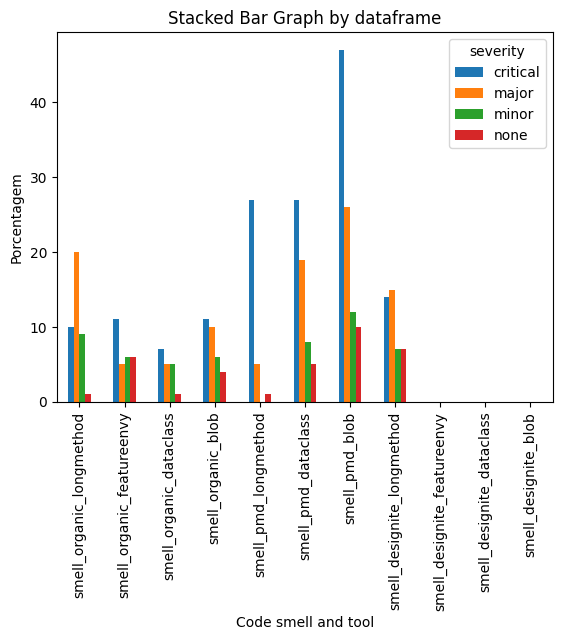

In [17]:
ax = df_severity.plot(x='index', kind='bar', stacked=False,
        title='Stacked Bar Graph by dataframe')
#ax = df_graph.plot(x='index', kind='bar', stacked=True, title='Stacked Bar Graph by dataframe')

ax.set_xlabel("Code smell and tool")
ax.set_ylabel("Porcentagem")
#ax.set_title("% of code smell agreement per tool and severity")

##Experts' Background X Agreement Smells Types




Analyze codesmell detection from developers' background

While analyzing experts' backgrounds, a hypothesis is that the more experienced an expert is, the higher the agreement of the manual labeling with the automatic labeling.



In [18]:
df_sum = df_result[['longmethod_label', 'featureenvy_label', 'dataclass_label', 'blob_label',
       'smell_organic_longmethod', 'smell_organic_featureenvy',
       'smell_organic_dataclass', 'smell_organic_blob',
       'smell_pmd_longmethod', 'smell_pmd_featureenvy',
       'smell_pmd_dataclass', 'smell_pmd_blob',
       'smell_designite_longmethod', 'smell_designite_featureenvy',
       'smell_designite_dataclass', 'smell_designite_blob', 'background']].copy()
df_sum = df_sum.groupby(['background'], dropna=False).sum()
df_sum


,longmethod_label,featureenvy_label,dataclass_label,blob_label,smell_organic_longmethod,smell_organic_featureenvy,smell_organic_dataclass,smell_organic_blob,smell_pmd_longmethod,smell_pmd_featureenvy,smell_pmd_dataclass,smell_pmd_blob,smell_designite_longmethod,smell_designite_featureenvy,smell_designite_dataclass,smell_designite_blob
background,,,,,,,,,,,,,,,,
Junior,56,84,149,137,3,5,2,4,4,0,21,28,6,0,0,0
Middle,125,108,185,250,23,5,14,13,7,0,28,25,16,0,0,0
Senior,746,682,1173,1247,83,42,39,94,26,0,122,214,66,0,0,0
NaN,243,257,515,493,14,13,25,29,8,0,56,83,26,0,0,0


In [19]:
df_background = df_sum.copy()
ComputePercent(df_background)
df_background = df_background[['smell_organic_longmethod', 'smell_organic_featureenvy', 'smell_organic_dataclass', 'smell_organic_blob',
  'smell_pmd_longmethod', 'smell_pmd_dataclass', 'smell_pmd_blob',
  'smell_designite_longmethod', 'smell_designite_featureenvy','smell_designite_dataclass', 'smell_designite_blob']]
# df_background = df_background.T
# df_background.reset_index(inplace=True)
df_background

,smell_organic_longmethod,smell_organic_featureenvy,smell_organic_dataclass,smell_organic_blob,smell_pmd_longmethod,smell_pmd_dataclass,smell_pmd_blob,smell_designite_longmethod,smell_designite_featureenvy,smell_designite_dataclass,smell_designite_blob
background,,,,,,,,,,,
Junior,5.0,6.0,1.0,3.0,7.0,14.0,20.0,11.0,0.0,0.0,0.0
Middle,18.0,5.0,8.0,5.0,6.0,15.0,10.0,13.0,0.0,0.0,0.0
Senior,11.0,6.0,3.0,8.0,3.0,10.0,17.0,9.0,0.0,0.0,0.0
NaN,6.0,5.0,5.0,6.0,3.0,11.0,17.0,11.0,0.0,0.0,0.0


In [20]:
# Add '%' to integer values in the DataFrame
df_sev_agreement = df_background.applymap(lambda x: str(round(x)) + '\%' if isinstance(x, float) else x)

# Aplicar a função a todos os elementos do DataFrame
df_sev_agreement = df_sev_agreement.applymap(add_string)

df_sev_agreement.insert(0, 'longmethod_label', ['','','',''])
df_sev_agreement.insert(1, 'featureenvy_label', ['','','',''])
df_sev_agreement.insert(2, 'dataclass_label', ['','','',''])
df_sev_agreement.insert(3, 'blob_label', ['','','',''])

# Converter todos os campos do DataFrame em strings
df_sums = df_sum.astype(str)
df_sev_agreement = df_sev_agreement.astype(str)

# # Somar os dois DataFrames
merged_df_2 = df_sums + df_sev_agreement
merged_df_2 = merged_df_2[['longmethod_label', 'featureenvy_label', 'dataclass_label', 'blob_label',
  'smell_organic_longmethod', 'smell_organic_featureenvy', 'smell_organic_dataclass', 'smell_organic_blob',
  'smell_pmd_longmethod', 'smell_pmd_dataclass', 'smell_pmd_blob',
  'smell_designite_longmethod','smell_designite_featureenvy','smell_designite_dataclass', 'smell_designite_blob']]

# Redefinir os nomes das colunas
novos_nomes = ['LM', 'FE', 'DC', 'Blob', 'LM', 'FE', 'DC', 'Blob', 'LM', 'DC', 'Blob', 'LM', 'FE','DC','Blob']
novos_nomes = ['LM', 'FE', 'DC', 'Blob', 'LM', 'FE', 'DC', 'Blob', 'LM', 'DC', 'Blob', 'LM', 'FE','DC','Blob']
merged_df_2.columns = novos_nomes
#print(merged_df, merged_df_2)
df_unido = pd.concat([merged_df, merged_df_2], ignore_index=False)


print(df_unido)

#display(merged_df_2)
df_unido=df_unido.T
# Convert DataFrame to LaTeX
latex_table = df_unido.to_latex(index=True)
# Print the LaTeX table
print(latex_table)


           LM   FE    DC  Blob         LM        FE        DC       Blob  \
critical   93   28   188   178   9 (10\%)  3 (11\%)  14 (7\%)  20 (11\%)   
major     329  154   477   399  66 (20\%)   8 (5\%)  26 (5\%)  39 (10\%)   
minor     528  321   641   730   45 (9\%)  18 (6\%)  30 (5\%)   45 (6\%)   
none      220  628   716   820    3 (1\%)  36 (6\%)  10 (1\%)   36 (4\%)   
Junior     56   84   149   137    3 (5\%)   5 (6\%)   2 (1\%)    4 (3\%)   
Middle    125  108   185   250  23 (18\%)   5 (5\%)  14 (8\%)   13 (5\%)   
Senior    746  682  1173  1247  83 (11\%)  42 (6\%)  39 (3\%)   94 (8\%)   
NaN       243  257   515   493   14 (6\%)  13 (5\%)  25 (5\%)   29 (6\%)   

                 LM          DC        Blob         LM       FE       DC  \
critical  25 (27\%)   51 (27\%)   83 (47\%)  13 (14\%)  0 (0\%)  0 (0\%)   
major      18 (5\%)   89 (19\%)  103 (26\%)  48 (15\%)  0 (0\%)  0 (0\%)   
minor       0 (0\%)    51 (8\%)   84 (12\%)   38 (7\%)  0 (0\%)  0 (0\%)   
none       

/tmp/ipython-input-1685113196.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sev_agreement = df_background.applymap(lambda x: str(round(x)) + '\%' if isinstance(x, float) else x)
/tmp/ipython-input-1685113196.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sev_agreement = df_sev_agreement.applymap(add_string)


In [ ]:
df_background = df_background.T
df_background.reset_index(inplace=True)
df_background

background,index,Junior,Middle,Senior,NaN
0,smell_Organic_longmethod,5.0,18.0,11.0,6.0
1,smell_Organic_featureenvy,6.0,5.0,6.0,5.0
2,smell_Organic_dataclass,1.0,8.0,3.0,5.0
3,smell_Organic_blob,3.0,5.0,8.0,6.0
4,smell_PMD_longmethod,7.0,6.0,3.0,3.0
5,smell_PMD_dataclass,14.0,15.0,10.0,11.0
6,smell_PMD_blob,20.0,10.0,17.0,17.0
7,smell_Designite_longmethod,11.0,13.0,9.0,11.0
8,smell_Designite_featureenvy,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Porcentagem')

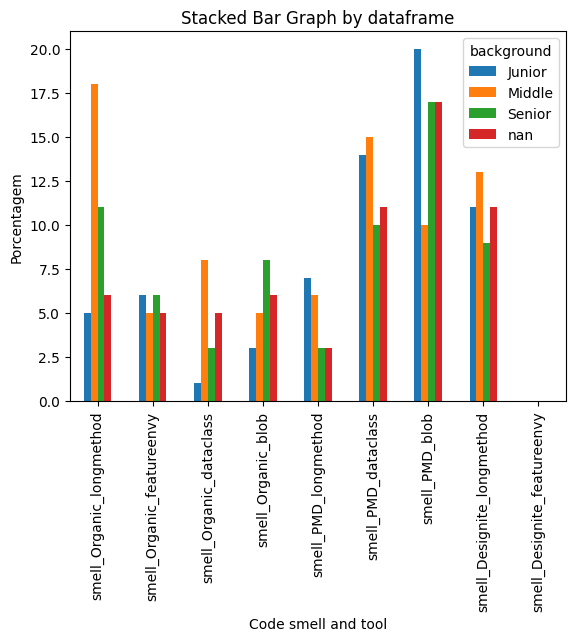

In [ ]:
ax = df_background.plot(x='index', kind='bar', stacked=False,
        title='Stacked Bar Graph by dataframe')
#ax = df_graph.plot(x='index', kind='bar', stacked=True, title='Stacked Bar Graph by dataframe')

ax.set_xlabel("Code smell and tool")
ax.set_ylabel("Porcentagem")
#ax.set_title("Code smell per tool and background")
